# Face Detection Notebook（MTCNN）
## Use Case: 集合写真から人数（顔数）をカウントし、構図を分析する

### 目的
集合写真に写る顔を検出し、人数・顔の大きさ（面積比）・位置などを数値化して構図の傾向を分析する。

### 使用手法
- MTCNN（精度が高く、小さな顔も検出しやすい）


### 使用画像について
本Notebookで使用した画像は、Unsplashより取得したフリー素材画像を利用している。  


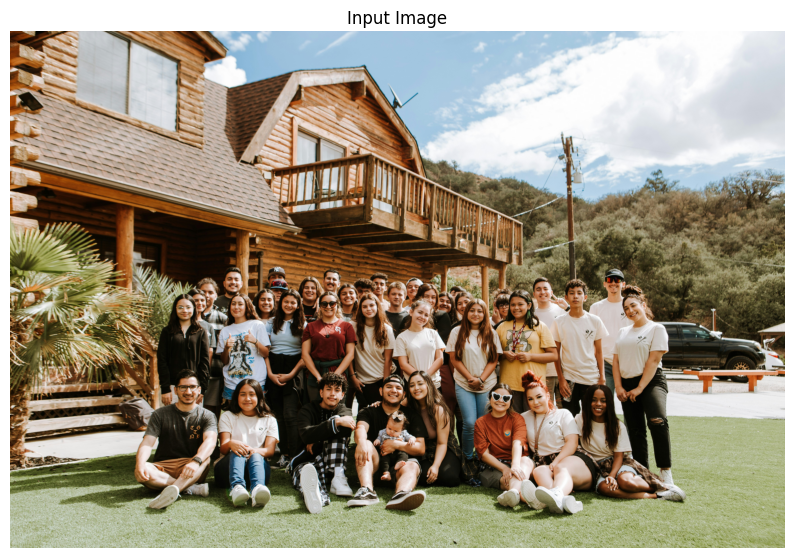

Image size (W, H): (5472, 3648)


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

IMG_PATH = "./images_group.jpg"  # ←ここに画像

img_pil = Image.open(IMG_PATH).convert("RGB")
img_np = np.array(img_pil)
H, W = img_np.shape[:2]

plt.figure(figsize=(10,7))
plt.imshow(img_np)
plt.axis("off")
plt.title("Input Image")
plt.show()

print("Image size (W, H):", (W, H))


## MTCNN について（コメント）
- 強み：小さい顔や複数人の顔でも検出しやすい傾向があり、顔検出に特化している。
- 弱み：YOLOより処理が重く、リアルタイム用途では遅くなる場合がある。暗い画像や横顔では精度が落ちることがある。


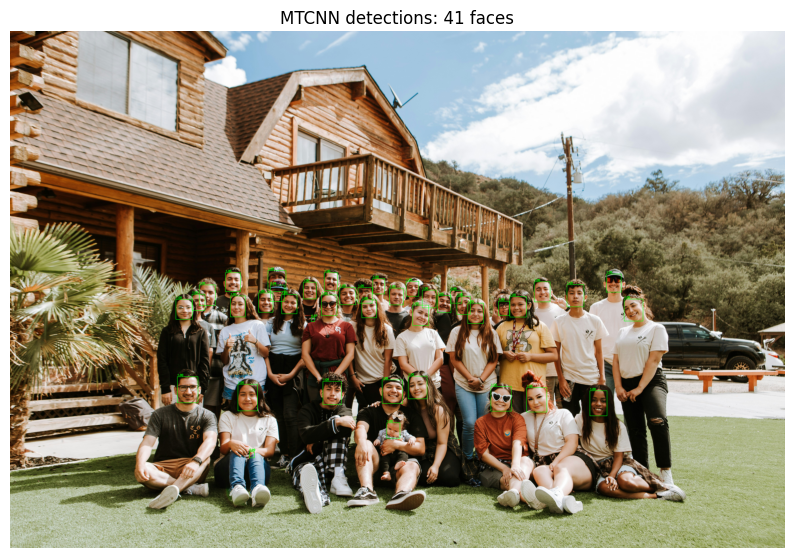

MTCNN face count: 41


In [12]:
from facenet_pytorch import MTCNN

mtcnn = MTCNN(keep_all=True)
boxes, probs = mtcnn.detect(img_pil)  # boxes: (N,4) [x1,y1,x2,y2]

vis_mtcnn = img_np.copy()
mtcnn_count = 0

if boxes is not None:
    for b, p in zip(boxes, probs):
        x1, y1, x2, y2 = map(int, b)
        cv2.rectangle(vis_mtcnn, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(vis_mtcnn, f"{p:.2f}", (x1, max(0, y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
        mtcnn_count += 1

plt.figure(figsize=(10,7))
plt.imshow(vis_mtcnn)
plt.axis("off")
plt.title(f"MTCNN detections: {mtcnn_count} faces")
plt.show()

print("MTCNN face count:", mtcnn_count)


In [13]:
def analyze_boxes_xyxy(boxes_xyxy, W, H):
    """
    boxes_xyxy: shape (N,4) with [x1,y1,x2,y2]
    """
    if boxes_xyxy is None or len(boxes_xyxy) == 0:
        return {
            "n_faces": 0,
            "avg_area_ratio": 0.0,
            "min_area_ratio": 0.0,
            "max_area_ratio": 0.0,
            "avg_center_x": None,
            "avg_center_y": None
        }

    areas = []
    centers = []
    for x1, y1, x2, y2 in boxes_xyxy:
        area = max(0, x2-x1) * max(0, y2-y1)
        areas.append(area / (W * H))
        centers.append(((x1+x2)/2 / W, (y1+y2)/2 / H))

    centers = np.array(centers)
    return {
        "n_faces": int(len(boxes_xyxy)),
        "avg_area_ratio": float(np.mean(areas)),
        "min_area_ratio": float(np.min(areas)),
        "max_area_ratio": float(np.max(areas)),
        "avg_center_x": float(np.mean(centers[:,0])),
        "avg_center_y": float(np.mean(centers[:,1])),
    }

mtcnn_stats = analyze_boxes_xyxy(boxes, W, H) if boxes is not None else analyze_boxes_xyxy(None, W, H)
mtcnn_stats


{'n_faces': 41,
 'avg_area_ratio': 0.0007450802162546128,
 'min_area_ratio': 3.371450498625995e-05,
 'max_area_ratio': 0.001346187929605415,
 'avg_center_x': 0.4799122427452173,
 'avg_center_y': 0.5684957341041941}

In [15]:
stats = analyze_boxes_xyxy(boxes, W, H)


In [16]:
print("=== Analysis Summary (MTCNN) ===")
print(f"Detected faces: {stats['n_faces']}")
print(f"Average face area ratio: {stats['avg_area_ratio']:.6f}")
print(f"Min face area ratio: {stats['min_area_ratio']:.6f}")
print(f"Max face area ratio: {stats['max_area_ratio']:.6f}")

if stats["avg_center_x"] is not None:
    print(f"Average face center (x, y): ({stats['avg_center_x']:.3f}, {stats['avg_center_y']:.3f})")


=== Analysis Summary (MTCNN) ===
Detected faces: 41
Average face area ratio: 0.000745
Min face area ratio: 0.000034
Max face area ratio: 0.001346
Average face center (x, y): (0.480, 0.568)


MTCNNによる顔検出の結果、画像内には41人分の顔が検出された。  
顔の平均面積比は約0.07%と小さく、多人数が写る集合写真であることが分かる。  
特に後列の顔は非常に小さく、検出が難しいケースであると考えられる。  
また、顔の平均位置は画像の中央付近に集中しており、集合写真として一般的な構図であることが確認できた。  


## 検出が難しかったケース
- 後列の小さい顔：顔が小さいため、見逃しが発生する可能性がある
- 横向きの顔：正面顔より信頼度が下がる場合がある
- サングラス・帽子：目や輪郭が隠れると誤検出/見逃しが起きやすい


## 所感
今回のテーマ（集合写真の人数カウントと構図分析）では、顔の「人数」「大きさ」「位置」を数値化するために顔検出が必要だった。  
MTCNNは顔検出に特化しており、集合写真のような複数人が写る画像でも顔を検出できた。一方で、後列の小さい顔や横向きの顔、帽子・サングラスなどで顔の特徴が隠れた場合は、見逃しや信頼度低下が起きる可能性があると感じた。  
このことから、精度重視の静止画分析ではMTCNNが有効だが、条件が悪い画像に対しては追加の工夫（画質改善、複数画像での検証など）が必要だと考えられる。
